# *FuseDream*: Training-Free Text-to-Image Generation with Improved CLIP+GAN Space Optimization.

By Xingchao Liu, Chengyue Gong, Lemeng Wu, Shujian Zhang, Hao Su and Qiang Liu from UCSD and UT Austin. (https://github.com/gnobitab/FuseDream). 

Following the commands in order to set up the environment and generate images with text queries using *FuseDream*.

This Colab notebook is the single image version of *FuseDream*. *FuseDream-Composition* will be shared in another Colab notebook.

A baseline method (BigSleep) was provided by https://twitter.com/advadnoun.


In [7]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.


In [3]:
!nvidia-smi

Sat Apr 30 20:55:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!git clone https://github.com/gnobitab/FuseDream.git
!pip install ftfy regex tqdm numpy scipy h5py lpips==0.1.4
!pip install git+https://github.com/openai/CLIP.git
!pip install gdown
!gdown 'https://drive.google.com/uc?id=17ymX6rhsgHDZw_g5XgAFW4xLSDocARCM'
!gdown 'https://drive.google.com/uc?id=1sOZ9og9kJLsqMNhaDnPJgzVsBZQ1sjZ5'

fatal: destination path 'FuseDream' already exists and is not an empty directory.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4lm5f9fm
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-4lm5f9fm
Downloading...
From: https://drive.google.com/uc?id=17ymX6rhsgHDZw_g5XgAFW4xLSDocARCM
To: /content/biggan-256.pth
100% 329M/329M [00:01<00:00, 251MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sOZ9og9kJLsqMNhaDnPJgzVsBZQ1sjZ5
To: /content/biggan-512.pth
100% 330M/330M [00:01<00:00, 301MB/s]


In [9]:
!ls
!cp biggan-256.pth FuseDream/BigGAN_utils/weights/
!cp biggan-512.pth FuseDream/BigGAN_utils/weights/
%cd FuseDream

biggan-256.pth	biggan-512.pth	FuseDream  sample_data
/content/FuseDream


In [13]:
import torch
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torchvision
import BigGAN_utils.utils as utils
import clip
import torch.nn.functional as F
from DiffAugment_pytorch import DiffAugment
import numpy as np
from fusedream_utils import FuseDreamBaseGenerator, get_G, save_image

### Setting up parameters
1. SENTENCE: The query text for generating the image. Note: we find that putting a period '.' at the end of the sentence can boost the quality of the generated images, e.g., 'A photo of a blue dog.' generates better images than 'A photo of a blue dog'.
2. INIT_ITERS: Controls the number of images used for initialization (M in the paper, and M = INIT_ITERS*10). Use the default number 1000 should work well.
3. OPT_ITERS: Controls the number of iterations for optimizing the latent variables. Use the default number 1000 should work well.
4. NUM_BASIS: Controls the number of basis images used in optimization (k in the paper). Choose from 5, 10, 15 should work well.
5. MODEL: Currently please choose from 'biggan-256' and 'biggan-512'.
6. SEED: Random seed. Choose an arbitrary integer you like.

In [18]:
#@title Parameters
SENTENCE = "A photo of a blue dog\"" #@param {type:"string"}
INIT_ITERS =  200#@param {type:"number"}
OPT_ITERS = 200#@param {type:"number"}
NUM_BASIS = 5#@param {type:"number"}
MODEL = "biggan-256" #@param ["biggan-256","biggan-512"]
SEED = 0#@param {type:"number"}

import sys
sys.argv = [''] ### workaround to deal with the argparse in Jupyter

Generating: A photo of a blue dog"
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  4.00it/s]


AugCLIP score: 0.346337890625


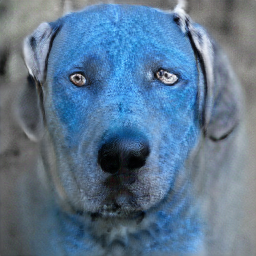

In [19]:
### Generation: Click the 'run' button and the final generated image will be shown after the end of the algorithm
utils.seed_rng(SEED) 

sentence = SENTENCE

print('Generating:', sentence)
if MODEL == "biggan-256":
    G, config = get_G(256) 
elif MODEL == "biggan-512":
    G, config = get_G(512) 
else:
    raise Exception('Model not supported')
generator = FuseDreamBaseGenerator(G, config, 10) 
z_cllt, y_cllt = generator.generate_basis(sentence, init_iters=INIT_ITERS, num_basis=NUM_BASIS)

z_cllt_save = torch.cat(z_cllt).cpu().numpy()
y_cllt_save = torch.cat(y_cllt).cpu().numpy()
img, z, y = generator.optimize_clip_score(z_cllt, y_cllt, sentence, latent_noise=False, augment=True, opt_iters=OPT_ITERS, optimize_y=True)
### Set latent_noise = True yields slightly higher AugCLIP score, but slightly lower image quality. We set it to False for dogs.
score = generator.measureAugCLIP(z, y, sentence, augment=True, num_samples=20)
print('AugCLIP score:', score)
import os
if not os.path.exists('./samples'):
    os.mkdir('./samples')
save_image(img, 'samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score))

from IPython import display
display.display(display.Image('samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score)))

Generating: I woke up too late today, must be the sun
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.97it/s]


AugCLIP score: 0.272412109375


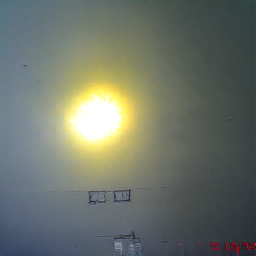

Generating: Aint got a fortune and I cant pretend to give
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:49<00:00,  4.00it/s]


AugCLIP score: 0.2974853515625


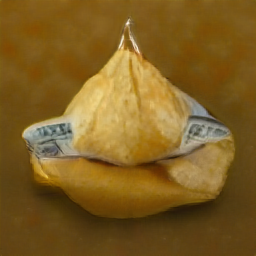

Generating: A little bit of greed mixed with some hard liquor
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.97it/s]


AugCLIP score: 0.30206298828125


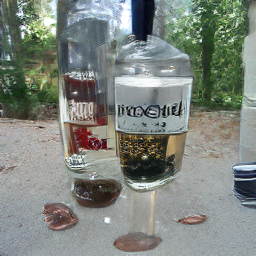

Generating: Some dogma thatll brainwash your world picture
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


AugCLIP score: 0.28792724609375


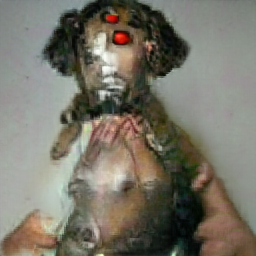

Generating: And a shock when you get mocked at the job you hate
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  4.00it/s]


AugCLIP score: 0.246807861328125


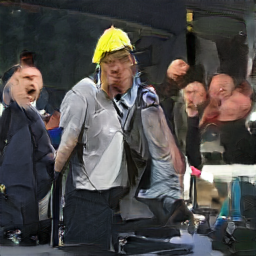

Generating: By the boss when you’re not co-operating
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


AugCLIP score: 0.26839599609375


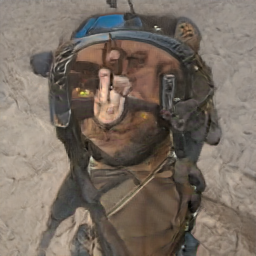

Generating: Cause youre not giving up while the world is shaking!
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


AugCLIP score: 0.26751708984375


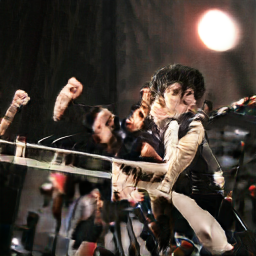

Generating: You waited this long, now stop debating
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


AugCLIP score: 0.2747802734375


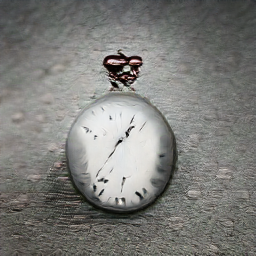

Generating: Cause we are back on the streets and demonstrating
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:49<00:00,  4.00it/s]


AugCLIP score: 0.2927734375


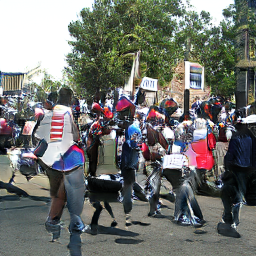

Generating: I know that you got a job, Ms. Teacher
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


AugCLIP score: 0.28372802734375


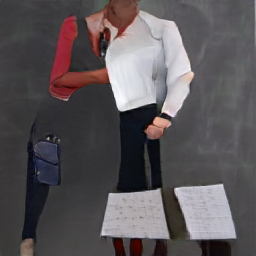

Generating: But our planets health problems complicating!
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  4.00it/s]


AugCLIP score: 0.2627685546875


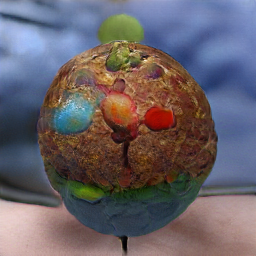

Generating: So the NDCs and SDGs
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


AugCLIP score: 0.2740478515625


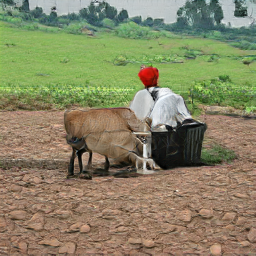

Generating: Are technically our last chance to keep
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:49<00:00,  4.03it/s]


AugCLIP score: 0.25372314453125


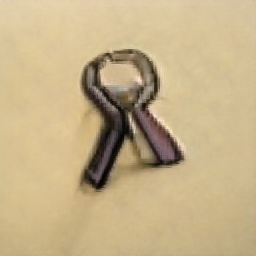

Generating: Global warming below 1.5 degrees
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


AugCLIP score: 0.27213134765625


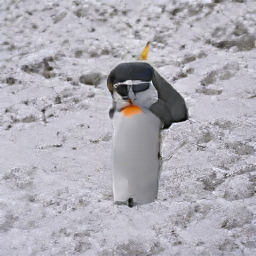

Generating: So Id say: Lets take to the streets
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.99it/s]


AugCLIP score: 0.2843994140625


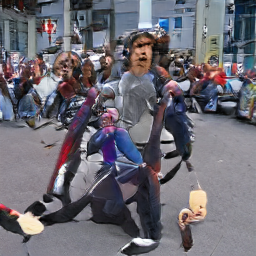

Generating: So call all your friends, tell em to dance
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.98it/s]


AugCLIP score: 0.294091796875


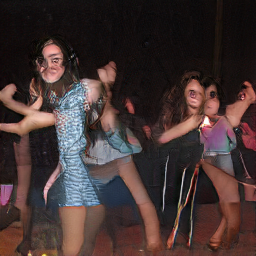

Generating: Cut that - Tell em to act and panic instead
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:49<00:00,  4.02it/s]


AugCLIP score: 0.2418212890625


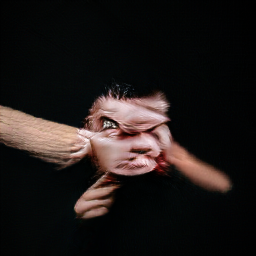

Generating: And get ready, cause this shits about to get heavy
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  3.97it/s]


AugCLIP score: 0.26837158203125


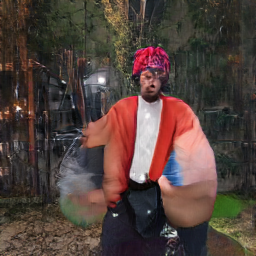

Generating: They be stealing our future
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 200/200 [00:50<00:00,  4.00it/s]


AugCLIP score: 0.273095703125


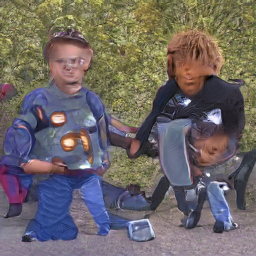

In [21]:
SENTENCES = ["I woke up too late today, must be the sun","Aint got a fortune and I cant pretend to give","A little bit of greed mixed with some hard liquor","Some dogma thatll brainwash your world picture","And a shock when you get mocked at the job you hate","By the boss when you’re not co-operating","Cause youre not giving up while the world is shaking!","You waited this long, now stop debating","Cause we are back on the streets and demonstrating","I know that you got a job, Ms. Teacher","But our planets health problems complicating!","So the NDCs and SDGs","Are technically our last chance to keep","Global warming below 1.5 degrees","So Id say: Lets take to the streets","So call all your friends, tell em to dance","Cut that - Tell em to act and panic instead","And get ready, cause this shits about to get heavy","They be stealing our future"]
INIT_ITERS =  200
OPT_ITERS = 200
NUM_BASIS = 5
MODEL = "biggan-256" 
SEED = 0

utils.seed_rng(SEED) 

for sentence in SENTENCES:
  print('Generating:', sentence)
  if MODEL == "biggan-256":
      G, config = get_G(256) 
  elif MODEL == "biggan-512":
      G, config = get_G(512) 
  else:
      raise Exception('Model not supported')
  generator = FuseDreamBaseGenerator(G, config, 10) 
  z_cllt, y_cllt = generator.generate_basis(sentence, init_iters=INIT_ITERS, num_basis=NUM_BASIS)

  z_cllt_save = torch.cat(z_cllt).cpu().numpy()
  y_cllt_save = torch.cat(y_cllt).cpu().numpy()
  img, z, y = generator.optimize_clip_score(z_cllt, y_cllt, sentence, latent_noise=False, augment=True, opt_iters=OPT_ITERS, optimize_y=True)
  ### Set latent_noise = True yields slightly higher AugCLIP score, but slightly lower image quality. We set it to False for dogs.
  score = generator.measureAugCLIP(z, y, sentence, augment=True, num_samples=20)
  print('AugCLIP score:', score)
  import os
  if not os.path.exists('./samples'):
      os.mkdir('./samples')
  save_image(img, 'samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score))

  from IPython import display
  display.display(display.Image('samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score)))